In [12]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import pyplot
from PIL import Image
import requests
from io import BytesIO
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from IPython.display import display
from sklearn import metrics
import advertools as adv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import plotly.express as px
import pickle
from xgboost import plot_importance
import plotly.graph_objects as go
import warnings
import optuna
from fitter import Fitter
warnings.filterwarnings('ignore')

## X_test FRQ ve SEV modeliyle predict edilmesi

df2 =  pd.read_csv("autodata.csv") # Müşteri bazında Frekans hesaplaması yapabilmek için ilk dataset i yeniden yüklüyoruz

df3 = df2.groupby("ID").agg({"CLAIM_FLAG":"sum",
                       "KIDSDRIV":"count"}).reset_index()
df3["FRQ"] = df3.CLAIM_FLAG / df3.KIDSDRIV
df3 = df3[["ID","FRQ"]].sort_values(by= "FRQ",ascending=False)
df4 = df2.merge(df3,how="left",on="ID")
df5 = df4.drop(["ID","CLM_AMT","CLAIM_FLAG"],axis=1) # "CLM_FREQ" ÇIKARMALI MI?

df = df5.copy()


for i in df.columns:
    if df[i].dtypes == "object":
        df[i] = df[i].str.replace("$","")
        df[i] = df[i].str.replace(",","")
        df[i] = df[i].str.replace("z_","")
        try: # BUNU OBJECTLER İÇİN YAPMAMASINI İSTİYORUZ . SAYI YAPMAYI DENE SAYI OLMUYOSA ÖYLE BIRAK. 
            df[i] = df[i].astype(float)
        except:
            pass
X = df.drop(["FRQ"],axis=1)
y = df.FRQ

X_train , X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 43, stratify=df.FRQ)

p1 = sum(y_train) / len(y_train)
p2 = sum(y_test) / len(y_test)
print(f"Train dataset freq mean : {p1:.2%}")
print(f"Test dataset freq mean : {p2:.2%}")



In [13]:
# load the FRQ Model
filename = 'FRQ_Model.sav'
freq_model = pickle.load(open(filename, 'rb'))
#result = freq_model.score(X_test, y_test,)# score R2 diyor, negeatif çıkarsa model kötüdür
                                            # modelin iyi olması için 1e yakın olmasını bekliyormuşuz.
#print(result)

# Target Encoding:
#X_train_target_encoded = X_train.copy()
#target_encoder = TargetEncoder()
#X_train_encoded = target_encoder.fit_transform(X_train_target_encoded, y_train)

#freq_model.fit(X_train_encoded,y_train)

#X_test = target_encoder.transform(X_test)
#pred_frq = freq_model.predict(X_test)
#pred_frq

In [14]:
#df_v = pd.DataFrame({"Actual" : y_test,
                     #"Pred" : pred})

#df_v[df_v.Actual == 1].Pred
#print(f"Ortalama Başarı : {y_test.mean() / pred.mean()}")
#print(f"Hasarlıların Ortalama Tahmini : {df_v[df_v.Actual == 1].Pred.mean():.2%}")
#print(f"Hasarsızların Ortalama Tahmini : {df_v[df_v.Actual == 0].Pred.mean():.2%}")

## SEVERITY PREDICTION

In [15]:
# load the SEV_Model
filename = 'SEV_Model.sav'
sev_model = pickle.load(open(filename, 'rb'))
#result = sev_model.score(X_test, y_test,)# score R2 diyor, negeatif çıkarsa model kötüdür
                                            # modelin iyi olması için 1e yakın olmasını bekliyormuşuz.
#print(result)

#df2 =  pd.read_csv("autodata.csv")
df2 =  pd.read_csv("cleaned_df1.csv")

df2 = df2[df2.CLAIM_FLAG == 1] # Yalnızca hasarlıları ele alıyoruz.
df = df2.copy()
for i in df.columns:
    if df[i].dtypes == "object":
        df[i] = df[i].str.replace('$' , '')
        df[i] = df[i].str.replace(',' , '')
        df[i] = df[i].str.replace("z_","")
        try:
            df[i] = df[i].astype(float)
        except:
            pass

df2 = df.copy()

df3 = df2.groupby("ID").agg({"CLAIM_FLAG":"sum",
                             "CLM_AMT" : "sum"}).reset_index()
df3["SEVERITY"] = df3.CLM_AMT / df3.CLAIM_FLAG
df3 = df3[["ID","SEVERITY"]].sort_values(by= "SEVERITY",ascending=False)
df4 = df2.merge(df3,how="left",on="ID")
df5 = df4.drop(["ID","CLM_AMT","CLAIM_FLAG"],axis=1)

df = df5.copy()

X = df.drop(["SEVERITY"],axis=1)
y = df.SEVERITY

X_train , X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 43) 

p1 = sum(y_train) / len(y_train)
p2 = sum(y_test) / len(y_test)
print(f"Train dataset SEVERITY mean : {p1:.2%}")
print(f"Test dataset SEVERITY mean : {p2:.2%}")


X_train_target_encoded = X_train.copy()
target_encoder = TargetEncoder()
X_train_encoded = target_encoder.fit_transform(X_train_target_encoded, y_train)

X_test = target_encoder.transform(X_test)

pred_sev = sev_model.predict(X_test)
pred_sev.shape

pred_frq = freq_model.predict(X_test)
pred_frq.shape

Train dataset SEVERITY mean : 571562.59%
Test dataset SEVERITY mean : 561235.45%


(386,)

## Pred FRQ X PRED sev = Baz prım hesaplanması (base prim)

In [16]:
base_prim = pred_frq*pred_sev

## Base prim ile toplam ödenen tutar karşılaştırılması

In [17]:
# Toplam ödenen tutar: CLM_AMT.sum() ( Ne kadar yakın çıkarsa o kdar iyi)
df2 = df2[df2.CLAIM_FLAG == 1]

# Severity için oluşturulan X_test deki indexler e denk gelen , X_test oluşturulan dataki CLM_AMT değerleri
X_test_CLM_AMT = df2.iloc[X_test.index]['CLM_AMT']

In [18]:
X_test_CLM_AMT - base_prim

4898     687.304443
5712    2499.798584
7122    1415.106323
6006    4414.515991
3961    3348.297852
           ...     
6380    2937.126953
6178    4563.569702
6523    6172.427002
1012    1524.333618
2398    2810.286133
Name: CLM_AMT, Length: 386, dtype: float64

In [19]:
 X_test_CLM_AMT.sum() - base_prim.sum()

1701964.46875

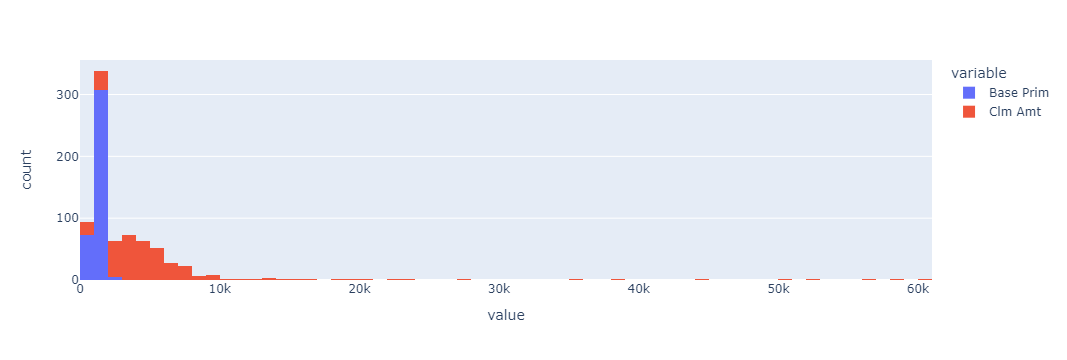

In [20]:
prob_data = pd.DataFrame({"Clm Amt" : X_test_CLM_AMT,
                          "Base Prim" : base_prim})

#prob_data2 = prob_data[prob_data.Actual < 10000]
fig = px.histogram(prob_data, x=["Base Prim","Clm Amt"])
fig.show()

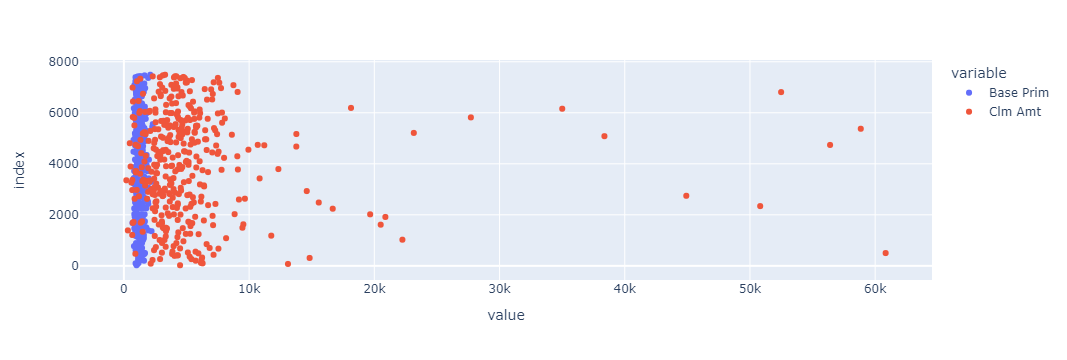

In [21]:
px.scatter(prob_data, x=["Base Prim","Clm Amt"])

In [22]:
########### YAPILANLARI VE SONUÇLARI SUNUM FORMATINA GETİR